<a href="https://colab.research.google.com/github/mitesh98/LSTM-Deep-Learning/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Reading Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
from bs4 import BeautifulSoup
from collections import Counter
from collections import OrderedDict 
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
np.random.seed(7)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

In [4]:
con=sqlite3.connect("database.sqlite")
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [6]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
df=filtered_data.sample(5000)


In [25]:
df.shape

(5000, 10)

In [26]:
#Deduplication of entries
final=df.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(4948, 10)

In [27]:
final=final[['Text','Score']]
final.head()

,Text,Score
52298,"Okay, we admit it: we're neither coffee nor te...",1
6207,Who knew juice could be so cool? It has a very...,1
363058,My mom is an avid green tea drinker. I have bo...,1
371762,"First of all, I think these candies are great....",1
75162,My dog just didn't like the taste of them whic...,0


# 2. Data Cleaning
** 2.1 Hyperlink Removal**

In [0]:
for i in range(0,4948):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

**2.2 html tags Removal**

In [0]:
#Remove HTML tags
for i in range(1,4948):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

# LSTM

# 3.1 Training Data Preparation

In [30]:
y=list(final['Score'])
reviews=list(final['Text']) #x
len(y)

4948

In [0]:
list_of_word=[]
for review in reviews:
  words=review.split()
  for word in words:
    list_of_word.append(word)

In [32]:
counts = Counter(list_of_word)
list_of_unique_word=list(counts.elements())
print("Total No of unique words :",len(list_of_unique_word))

Total No of unique words : 370285


In [33]:
#No of top words we have to take=5000
no_of_top_words=5000
top=counts.most_common(no_of_top_words)
top_words=[]
for word in top:
  top_words.append(word[0])
print("Top words\tFrequency")
for i in range(0,10):
  print(top[i][0],"\t\t",top[i][1])

Top words	Frequency
the 		 13242
I 		 11254
and 		 10162
a 		 9589
to 		 8081
of 		 6381
is 		 5917
it 		 5084
for 		 4292
in 		 4256


In [0]:
x_list=[]
i=0
for review in reviews:
  index_list=[]
  for word in review.split():
    try:
      if word in top_words:
        index_list.append(top_words.index(word))
    except:
      print(word,": Not found")
  x_list.append(index_list)
  i+=1

**Splitting into train and test**

In [0]:
y_train=y[0:3958]
x_train=x_list[0:3958]
y_test=y[3958:]
x_test=x_list[3958:]

In [36]:
print("training size of x= {} y= {}".format(len(y_train),len(x_train)))
print("test size of x= {} y= {}" .format(len(y_test) ,len(x_test)))

training size of x= 3958 y= 3958
test size of x= 990 y= 990


In [37]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[3386, 1122, 526, 131, 28, 24, 36, 38, 3, 33, 1055, 40, 2, 31, 0, 191, 254, 5, 174, 1432, 96, 6, 66, 757, 8, 10, 2305, 1, 81, 11, 684, 5, 1976, 42, 28, 298, 0, 35, 3726, 4, 372, 23, 53, 3, 40, 5, 10, 54, 2302]
<class 'list'>
49


# 3.2 **Padding**

In [38]:
max_review_length = 600
x_train=sequence.pad_sequences(x_train,maxlen=max_review_length)
x_test=sequence.pad_sequences(x_test,maxlen=max_review_length)
print("Training data Shape",x_train.shape)
print(x_train[1])

Training data Shape (3958, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

# Architecture-1

In [39]:
embedding_vector_length=32
model=Sequential()
model.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3958 samples, validate on 990 samples
Epoch 1/10
3958/3958 [==============================] - 81s 20ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.7272 - val_acc: 0.8828
Epoch 2/10
3958/3958 [==============================] - 81s 20ms/step - loss: 7.9504e-04 - acc: 1.0000 - val_loss: 0.7401 - val_acc: 0.8828
Epoch 3/10
3958/3958 [==============================] - 80s 20ms/step - loss: 5.6745e-04 - acc: 1.0000 - val_loss: 0.7701 - val_acc: 0.8828
Epoch 4/10
3958/3958 [==============================] - 80s 20ms/step - loss: 4.5361e-04 - acc: 1.0000 - val_loss: 0.7999 - val_acc: 0.8818
Epoch 5/10
3958/3958 [==============================] - 80s 20ms/step - loss: 3.5163e-04 - acc: 1.0000 - val_loss: 0.8169 - val_acc: 0.8808
Epoch 6/10
3958/3958 [==============================] - 81s 20ms/step - loss: 0.0391 - acc: 0.9848 - val_loss: 0.4863 - val_acc: 0.8616
Epoch 7/10
3958/3958 [==============================] - 80s 20ms/step - loss: 0.0409 - acc: 0.9859 - val_loss: 0.5178 - v

Test Loss:0.7187 
Test Accuracy: 0.8899


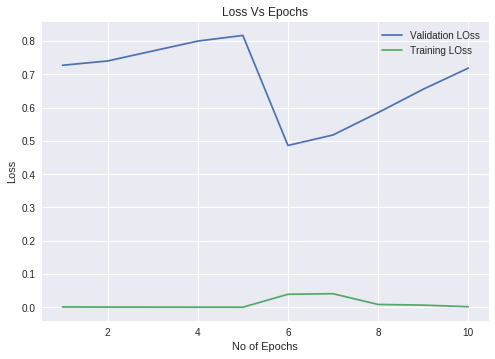

In [45]:
# Final evaluation of the model
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

# Architecture-2

In [67]:
embedding_vector_length=16
model=Sequential()
model.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 600, 16)           80000     
_________________________________________________________________
lstm_26 (LSTM)               (None, 600, 100)          46800     
_________________________________________________________________
lstm_27 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 207,301
Trainable params: 207,301
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3958 samples, validate on 990 samples
Epoch 1/10
3958/3958 [==============================] - 168s 42ms/step - loss: 0.4713 - acc: 0.8459 - val_loss: 0.3994 - val_acc: 0.8626
Epoch 2/10
3958/3958 [==============================] - 165s 42ms/step - loss: 0.3887 - acc: 0.8560 - val_loss: 0.3304 - val_acc: 0.8737
Epoch 3/10
3958/3958 [==============================] - 164s 41ms/step - loss: 0.2088 - acc: 0.9186 - val_loss: 0.3110 - val_acc: 0.8838
Epoch 4/10
3958/3958 [==============================] - 166s 42ms/step - loss: 0.1073 - acc: 0.9651 - val_loss: 0.4015 - val_acc: 0.8879
Epoch 5/10
3958/3958 [==============================] - 164s 41ms/step - loss: 0.0624 - acc: 0.9798 - val_loss: 0.4163 - val_acc: 0.8778
Epoch 6/10
3958/3958 [==============================] - 165s 42ms/step - loss: 0.0371 - acc: 0.9886 - val_loss: 0.4914 - val_acc: 0.8727
Epoch 7/10
3958/3958 [==============================] - 165s 42ms/step - loss: 0.0181 - acc: 0.9957 - val_loss: 0.5148 - val_acc: 0

Test Loss:0.7402 
Test Accuracy: 0.8818


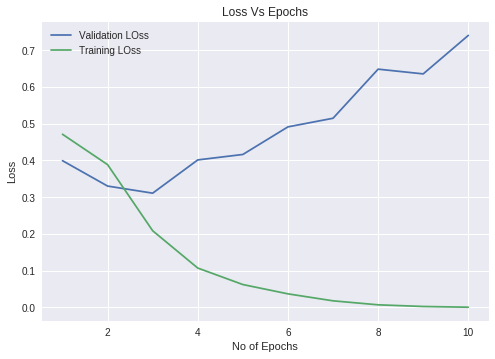

In [69]:
# Final evaluation of the model
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

**No of epoch =3**

# Architecture -3

In [64]:
embedding_vector_length=32
model=Sequential()
model.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_23 (LSTM)               (None, 600, 32)           8320      
_________________________________________________________________
lstm_24 (LSTM)               (None, 600, 32)           8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 184,993
Trainable params: 184,993
Non-trainable params: 0
_________________________________________________________________
None

In [65]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3958 samples, validate on 990 samples
Epoch 1/10
3958/3958 [==============================] - 82s 21ms/step - loss: 0.4902 - acc: 0.8406 - val_loss: 0.3951 - val_acc: 0.8626
Epoch 2/10
3958/3958 [==============================] - 77s 19ms/step - loss: 0.3631 - acc: 0.8575 - val_loss: 0.3330 - val_acc: 0.8626
Epoch 3/10
3958/3958 [==============================] - 76s 19ms/step - loss: 0.1938 - acc: 0.9275 - val_loss: 0.3418 - val_acc: 0.8818
Epoch 4/10
3958/3958 [==============================] - 76s 19ms/step - loss: 0.0967 - acc: 0.9666 - val_loss: 0.4062 - val_acc: 0.8808
Epoch 5/10
3958/3958 [==============================] - 77s 19ms/step - loss: 0.0527 - acc: 0.9843 - val_loss: 0.4346 - val_acc: 0.8747
Epoch 6/10
3958/3958 [==============================] - 77s 19ms/step - loss: 0.0285 - acc: 0.9919 - val_loss: 0.4942 - val_acc: 0.8737
Epoch 7/10
3958/3958 [==============================] - 77s 19ms/step - loss: 0.0165 - acc: 0.9962 - val_loss: 0.5904 - val_acc: 0.8636
E

Test Loss:0.6600 
Test Accuracy: 0.8798


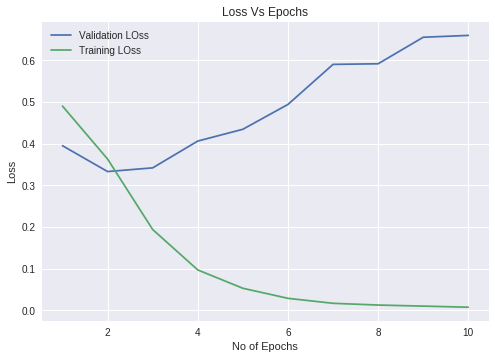

In [66]:
# Final evaluation of the model
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

# Conclusion:


In [71]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['No of LSTM','units','Accuracy']
x.add_row(['1','100','  0.8899'])
x.add_row(['2','100',' 0.8818'])
x.add_row(['3','32',' 0.8798'])
print(x)

+------------+-------+----------+
| No of LSTM | units | Accuracy |
+------------+-------+----------+
|     1      |  100  |   0.8899 |
|     2      |  100  |  0.8818  |
|     3      |   32  |  0.8798  |
+------------+-------+----------+


# Observations:
 1. Architecture -1 has gone underfitting
 
 2. Architecture -2 after third epoch it  started overfitting
 
  2. Architecture -3 after second epoch it  started overfitting